# Survivability Analysis

### Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from IPython.display import display, Markdown

### Define Paths

In [2]:
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD

PROCESSED = ROOT / "data" / "processed"
OUTPUTS = ROOT / "outputs"

SURVIVABILITY_DIR = OUTPUTS / "survivability"
FIGURES_SURV = SURVIVABILITY_DIR / "figures"
TABLES_SURV = SURVIVABILITY_DIR / "tables"

for p in [FIGURES_SURV, TABLES_SURV]:
    p.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version.split()[0])
print("FIGURES_SURV:", FIGURES_SURV)
print("TABLES_SURV:", TABLES_SURV)

Python: 3.11.9
FIGURES_SURV: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\outputs\survivability\figures
TABLES_SURV: C:\Users\danci\Interconnection-Queue-Intelligence\Interconnection-Queue-Intelligence\outputs\survivability\tables


### Load Processed Files

In [3]:
public_path = PROCESSED / "public_queue_clean_combined.csv"
c15_path = PROCESSED / "cluster15_clean_combined.csv"
c14_path = PROCESSED / "cluster14_clean.csv"

for p in [public_path, c15_path, c14_path]:
    print(p.name, "exists:", p.exists())

public = pd.read_csv(public_path)
c15 = pd.read_csv(c15_path)
c14 = pd.read_csv(c14_path)

display(pd.DataFrame({
    "dataset": ["public", "cluster15", "cluster14"],
    "rows": [len(public), len(c15), len(c14)],
    "cols": [public.shape[1], c15.shape[1], c14.shape[1]],
}))

public_queue_clean_combined.csv exists: True
cluster15_clean_combined.csv exists: True
cluster14_clean.csv exists: True


,dataset,rows,cols
0,public,2290,24
1,cluster15,170,24
2,cluster14,363,14


### Helpers

In [4]:
def to_float(s):
    return pd.to_numeric(s, errors="coerce")

def to_dt(s):
    return pd.to_datetime(s, errors="coerce")

def norm_tech(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    if s == "": return ""
    if any(k in s for k in ["battery", "storage", "bess"]): return "storage"
    if any(k in s for k in ["solar", "pv", "photovoltaic"]): return "solar"
    if "wind" in s: return "wind"
    return str(x).strip()

def tech_group_row(row):
    t1 = norm_tech(row.get("tech_1",""))
    t2 = norm_tech(row.get("tech_2",""))
    t3 = norm_tech(row.get("tech_3",""))
    techs = sorted(set([t for t in [t1,t2,t3] if t != ""]))

    if not techs:
        return "unknown"
    if len(techs) >= 3:
        return "hybrid_multi"
    if techs == ["solar","storage"]:
        return "hybrid_solar_storage"
    if techs == ["solar","wind"]:
        return "hybrid_solar_wind"
    if techs == ["storage","wind"]:
        return "hybrid_storage_wind"
    if len(techs) == 1:
        return techs[0]
    return "hybrid_other"

def prep(df):
    df = df.copy()

    if "mw_poi" in df.columns:
        df["mw_poi"] = to_float(df["mw_poi"])
    else:
        df["mw_poi"] = np.nan

    for t in ["tech_1","tech_2","tech_3"]:
        if t in df.columns:
            df[t] = df[t].map(norm_tech)
        else:
            df[t] = ""

    df["tech_group"] = df.apply(tech_group_row, axis=1)

    if "sheet_outcome" not in df.columns:
        df["sheet_outcome"] = "unknown"

    for d in ["date_queue","date_received","date_application","date_withdrawn","date_cod_current_or_actual","date_cod_requested"]:
        if d in df.columns:
            df[d] = to_dt(df[d])

    return df

public = prep(public)
c15 = prep(c15)
c14 = prep(c14)

display(Markdown("**Outcome counts:**"))
display(pd.DataFrame({
    "public": public["sheet_outcome"].value_counts().to_dict(),
    "cluster15": c15["sheet_outcome"].value_counts().to_dict(),
    "cluster14": c14["sheet_outcome"].value_counts().to_dict(),
}))

**Outcome counts:**

,public,cluster15,cluster14
withdrawn,1718.0,62.0,NaN
active,335.0,108.0,NaN
completed,237.0,NaN,NaN
intake_snapshot,NaN,NaN,363.0


# Analysis

## 1) Outcome Distribution by Capacity

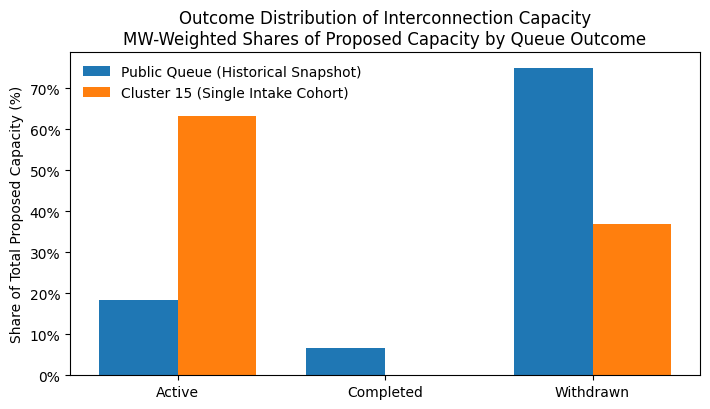

**Public Queue: MW by outcome**

,mw_sum
sheet_outcome,
active,90191.1400
completed,32932.8874
withdrawn,369257.4747


**Cluster 15: MW by outcome**

,mw_sum
sheet_outcome,
active,37245.20
withdrawn,21767.51


In [5]:
def mw_share_by_outcome(df):
    g = df.groupby("sheet_outcome")["mw_poi"].sum(min_count=1).fillna(0)
    share = (g / g.sum()).fillna(0)
    return g, share

pub_mw, pub_share = mw_share_by_outcome(public)
c15_mw, c15_share = mw_share_by_outcome(c15)

preferred_order = ["active", "completed", "withdrawn"]
outcomes = [o for o in preferred_order if o in set(pub_share.index).union(set(c15_share.index))]
outcomes += [o for o in sorted(set(pub_share.index).union(set(c15_share.index))) if o not in outcomes]

a = pub_share.reindex(outcomes).fillna(0).values
b = c15_share.reindex(outcomes).fillna(0).values

x = np.arange(len(outcomes))
w = 0.38

plt.figure(figsize=(7.2, 4.2))
plt.bar(x - w/2, a, width=w, label="Public Queue (Historical Snapshot)")
plt.bar(x + w/2, b, width=w, label="Cluster 15 (Single Intake Cohort)")

plt.xticks(x, [o.title() for o in outcomes], rotation=0)
plt.ylabel("Share of Total Proposed Capacity (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title(
    "Outcome Distribution of Interconnection Capacity\n"
    "MW-Weighted Shares of Proposed Capacity by Queue Outcome"
)
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig(
    FIGURES_SURV / "01_outcome_distribution_by_capacity_public_vs_cluster15.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(Markdown("**Public Queue: MW by outcome**")); display(pub_mw.to_frame("mw_sum"))
display(Markdown("**Cluster 15: MW by outcome**")); display(c15_mw.to_frame("mw_sum"))

## 2) Timing of Withdrawal & Completion

In [6]:
pub = public.copy()

pub["event_date"] = pd.NaT
if "date_withdrawn" in pub.columns:
    pub.loc[pub["sheet_outcome"].eq("withdrawn"), "event_date"] = pub.loc[pub["sheet_outcome"].eq("withdrawn"), "date_withdrawn"]
if "date_cod_current_or_actual" in pub.columns:
    pub.loc[pub["sheet_outcome"].eq("completed"), "event_date"] = pub.loc[pub["sheet_outcome"].eq("completed"), "date_cod_current_or_actual"]

if "date_queue" in pub.columns:
    pub["duration_days"] = (pub["event_date"] - pub["date_queue"]).dt.days
else:
    pub["duration_days"] = np.nan

timing = pub[pub["sheet_outcome"].isin(["withdrawn","completed"])].copy()
timing = timing[timing["duration_days"].notna() & (timing["duration_days"] >= 0)]

display(Markdown(f"**Rows with usable timing:** {len(timing)}"))

**Rows with usable timing:** 1901

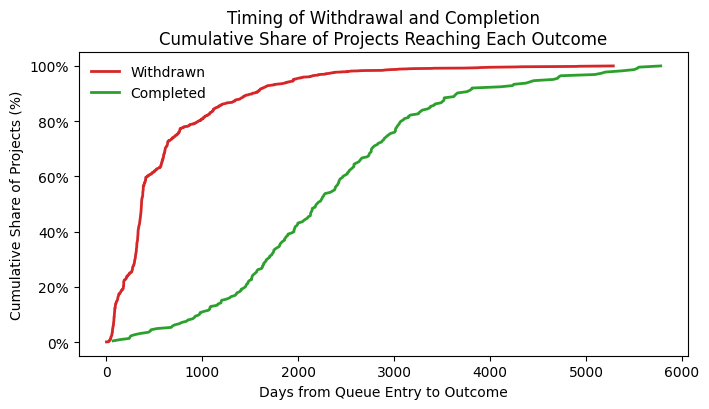

In [10]:
def ecdf(vals):
    v = np.sort(np.array(vals))
    y = np.arange(1, len(v) + 1) / len(v)
    return v, y

OUTCOME_COLORS = {
    "withdrawn": "tab:red",
    "completed": "tab:green",
}

plt.figure(figsize=(7.2, 4.2))

for outcome in ["withdrawn", "completed"]:
    vals = timing.loc[timing["sheet_outcome"].eq(outcome), "duration_days"].values
    if len(vals) < 5:
        continue
    x, y = ecdf(vals)
    plt.plot(x, y, label=outcome.title(), color=OUTCOME_COLORS.get(outcome, None), linewidth=2.0)

plt.xlabel("Days from Queue Entry to Outcome")
plt.ylabel("Cumulative Share of Projects (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title(
    "Timing of Withdrawal and Completion\n"
    "Cumulative Share of Projects Reaching Each Outcome"
)
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig(
    FIGURES_SURV / "02_timing_withdrawal_vs_completion_ecdf.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

## 3) Technology Composition of Interconnection Capacity

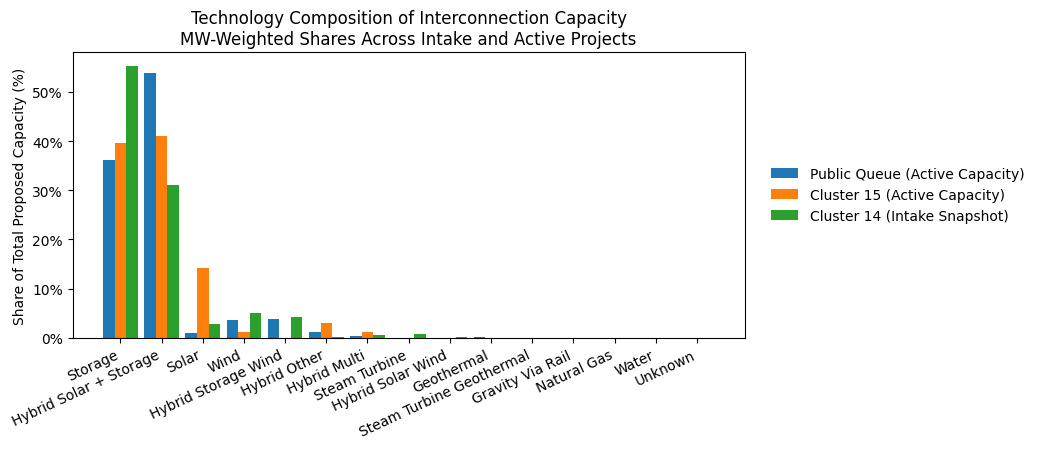

**Technology Mix Tables (MW Share):**

,Public Queue (Active),Cluster 15 (Active),Cluster 14 (Intake)
tech_group,,,
Geothermal,0.000588,0.000000,0.000000
Gravity via Rail,0.000488,0.000000,0.000000
Natural Gas,0.000388,0.000000,0.000000
Steam Turbine,0.000000,0.000000,0.006963
Steam Turbine Geothermal,0.000000,0.000000,0.000500
Water,0.000055,0.000000,0.000000
hybrid_multi,0.004435,0.010740,0.004717
hybrid_other,0.011200,0.029507,0.001604
hybrid_solar_storage,0.537326,0.410791,0.309901


In [8]:
def clean_tech_label(label: str) -> str:
    s = str(label).replace("_", " ")
    s = s.replace("hybrid solar storage", "Hybrid Solar + Storage")
    s = s.replace("solar storage", "Solar + Storage")
    return s.title()

public_active = public[public["sheet_outcome"].eq("active")].copy()
c15_active = c15[c15["sheet_outcome"].eq("active")].copy()
c14_intake = c14.copy()  # intake snapshot

def tech_mix(df):
    g = df.groupby("tech_group")["mw_poi"].sum(min_count=1).fillna(0)
    return (g / g.sum()).fillna(0)

mix_pub = tech_mix(public_active)
mix_15 = tech_mix(c15_active)
mix_14 = tech_mix(c14_intake)

cats = (
    pd.concat([mix_pub, mix_15, mix_14], axis=1)
      .fillna(0)
      .sum(axis=1)
      .sort_values(ascending=False)
      .index
      .tolist()
)

a = mix_pub.reindex(cats).fillna(0).values
b = mix_15.reindex(cats).fillna(0).values
c = mix_14.reindex(cats).fillna(0).values

pretty_labels = [clean_tech_label(t) for t in cats]

x = np.arange(len(cats))
w = 0.28

plt.figure(figsize=(10.5, 4.6))
plt.bar(x - w, a, width=w, label="Public Queue (Active Capacity)")
plt.bar(x,     b, width=w, label="Cluster 15 (Active Capacity)")
plt.bar(x + w, c, width=w, label="Cluster 14 (Intake Snapshot)")

plt.xticks(x, pretty_labels, rotation=25, ha="right")
plt.ylabel("Share of Total Proposed Capacity (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title(
    "Technology Composition of Interconnection Capacity\n"
    "MW-Weighted Shares Across Intake and Active Projects"
)

plt.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()

plt.savefig(
    FIGURES_SURV / "03_technology_mix_mw_weighted_public_vs_clusters.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(Markdown("**Technology Mix Tables (MW Share):**"))
display(pd.DataFrame({
    "Public Queue (Active)": mix_pub,
    "Cluster 15 (Active)": mix_15,
    "Cluster 14 (Intake)": mix_14
}).fillna(0))

## 4) Withdrawal Shares by Technology

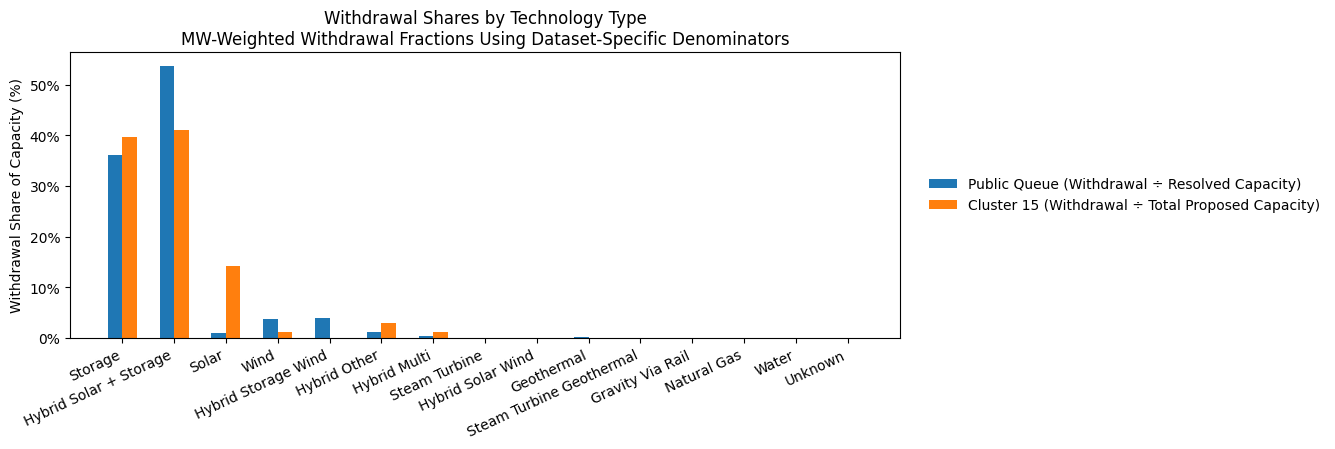

In [9]:
plt.figure(figsize=(13.5, 4.6))
plt.bar(
    x - w/2, a, width=w,
    label="Public Queue (Withdrawal ÷ Resolved Capacity)"
)
plt.bar(
    x + w/2, b, width=w,
    label="Cluster 15 (Withdrawal ÷ Total Proposed Capacity)"
)

plt.xticks(x, pretty_labels, rotation=25, ha="right")
plt.ylabel("Withdrawal Share of Capacity (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title(
    "Withdrawal Shares by Technology Type\n"
    "MW-Weighted Withdrawal Fractions Using Dataset-Specific Denominators"
)

plt.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()

plt.savefig(
    FIGURES_SURV / "04_withdrawal_shares_by_technology.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

## 5) Distribution of Capacity by Transmission Owner

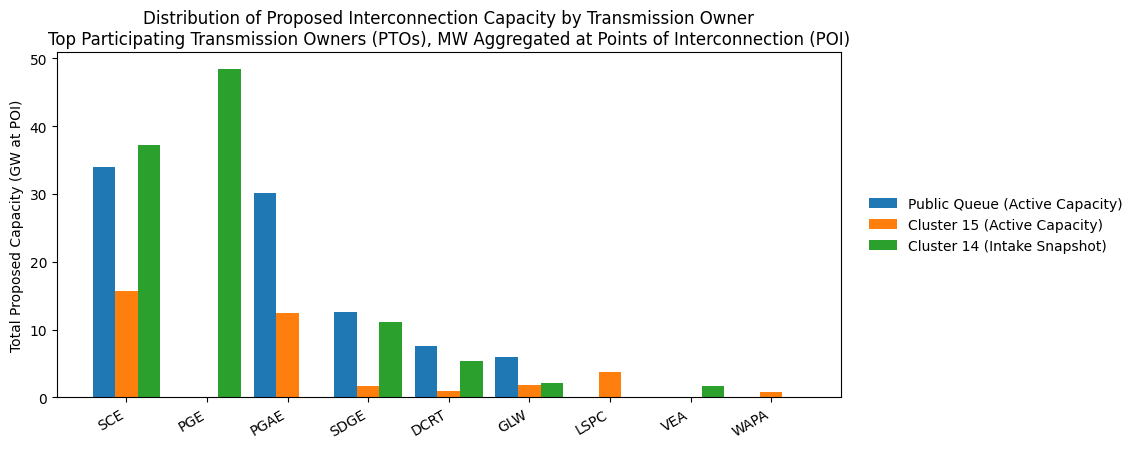

,pto,mw_sum,label
13,PGE,48479.2858,Cluster 14 (Intake)
14,SCE,37189.0000,Cluster 14 (Intake)
15,SDGE,11130.0000,Cluster 14 (Intake)
16,DCRT,5400.0000,Cluster 14 (Intake)
17,GLW,2150.0000,Cluster 14 (Intake)
18,VEA,1647.0000,Cluster 14 (Intake)
6,SCE,15669.2600,Cluster 15 (Active)
7,PGAE,12444.1100,Cluster 15 (Active)
8,LSPC,3812.0000,Cluster 15 (Active)
9,GLW,1800.0200,Cluster 15 (Active)


In [43]:
def top_pto(df, label, top_n=12):
    if "pto" not in df.columns:
        return pd.DataFrame(columns=["pto", "mw_sum", "label"])
    g = (
        df.groupby("pto")["mw_poi"]
          .sum(min_count=1)
          .fillna(0)
          .sort_values(ascending=False)
          .head(top_n)
    )
    out = g.rename("mw_sum").to_frame().reset_index()
    out["label"] = label
    return out

t_pub = top_pto(public_active, "Public Queue (Active)", 12)
t_15  = top_pto(c15_active, "Cluster 15 (Active)", 12)
t_14  = top_pto(c14_intake, "Cluster 14 (Intake)", 12)

union = pd.concat([t_pub, t_15, t_14], ignore_index=True)

ptos = (
    union.groupby("pto")["mw_sum"]
         .sum()
         .sort_values(ascending=False)
         .head(12)
         .index
         .tolist()
)

def series(label):
    s = union.loc[union["label"].eq(label)].set_index("pto")["mw_sum"]
    return s.reindex(ptos).fillna(0).values

a = series("Public Queue (Active)")
b = series("Cluster 15 (Active)")
c = series("Cluster 14 (Intake)")

to_gw = 1_000.0
a_gw, b_gw, c_gw = a / to_gw, b / to_gw, c / to_gw

x = np.arange(len(ptos))
w = 0.28

plt.figure(figsize=(11.5, 4.6))
plt.bar(x - w, a_gw, width=w, label="Public Queue (Active Capacity)")
plt.bar(x,     b_gw, width=w, label="Cluster 15 (Active Capacity)")
plt.bar(x + w, c_gw, width=w, label="Cluster 14 (Intake Snapshot)")

plt.xticks(x, ptos, rotation=30, ha="right")
plt.ylabel("Total Proposed Capacity (GW at POI)")

plt.title(
    "Distribution of Proposed Interconnection Capacity by Transmission Owner\n"
    "Top Participating Transmission Owners (PTOs), MW Aggregated at Points of Interconnection (POI)"
)

plt.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()

plt.savefig(
    FIGURES_SURV / "05_capacity_by_transmission_owner_top_ptos.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

display(union.sort_values(["label", "mw_sum"], ascending=[True, False]).head(30))

### Save Tables

In [44]:
tab.to_csv(TABLES_SURV / "withdrawal_signal_by_tech.csv", index=False)

pd.DataFrame({
    "public_mw": pub_mw,
    "public_share": pub_share
}).to_csv(TABLES_SURV / "public_outcome_mw.csv", index=False)

pd.DataFrame({
    "cluster15_mw": c15_mw,
    "cluster15_share": c15_share
}).to_csv(TABLES_SURV / "cluster15_outcome_mw.csv", index=False)

pd.DataFrame({
    "public_active": mix_pub,
    "cluster15_active": mix_15,
    "cluster14_intake": mix_14
}).fillna(0).to_csv(TABLES_SURV / "intake_tech_mix_mw.csv", index=False)

union.to_csv(TABLES_SURV / "top_pto_mw_union.csv", index=False)